In [45]:
import sys
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn import preprocessing
from sklearn.metrics import precision_score
import os
data_path = "./data/"

In [46]:
root_dir = "."

def image_path(author, fig_id):
    return os.path.join(root_dir, "image", user, fig_id)

def save_fig(fig_id, tight_layout=True):
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(image_path("takeryo", fig_id), ".png", format="png", dpi=300)
    
def replace_outlier(series, bias=1.5):
    #四分位数
    q1 = series.quantile(.25)
    q3 = series.quantile(.75)
    iqr = q3 - q1

    #外れ値の基準点
    outlier_min = q1 - (iqr) * bias
    outlier_max = q3 + (iqr) * bias

    print("outlier_min :" + str(outlier_min) + ", outlier_max :" + str(outlier_max))

    #外れ値をクリップする
    series = series.clip(outlier_min, outlier_max)
    return series

In [47]:
#トレインデータをpandasで取得
train_data = pd.read_csv("data/application_train.csv")
test_data =  pd.read_csv("data/application_test.csv")

In [48]:
train_data["AMT_INCOME_TOTAL"] = replace_outlier(train_data["AMT_INCOME_TOTAL"])

outlier_min :-22500.0, outlier_max :337500.0


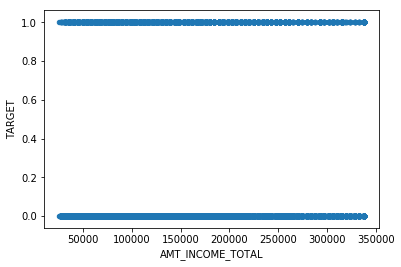

In [49]:
train_data.plot.scatter(x = "AMT_INCOME_TOTAL", y = "TARGET")

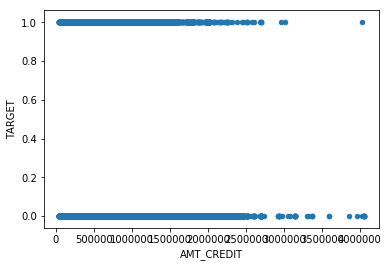

In [50]:
train_data.plot.scatter(x = "AMT_CREDIT", y = "TARGET")

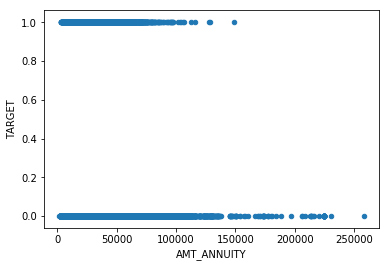

In [71]:
train_data.plot.scatter(x = "AMT_ANNUITY", y = "TARGET")

In [52]:
col_list = ["NAME_CONTRACT_TYPE","CODE_GENDER", "FLAG_OWN_CAR", "FLAG_OWN_REALTY", "CNT_CHILDREN", "AMT_INCOME_TOTAL", "AMT_CREDIT", "AMT_ANNUITY"]

In [53]:
train_x = train_data[col_list]
train_y = train_data["TARGET"]

In [54]:
train_x.isnull().any()

NAME_CONTRACT_TYPE    False
CODE_GENDER           False
FLAG_OWN_CAR          False
FLAG_OWN_REALTY       False
CNT_CHILDREN          False
AMT_INCOME_TOTAL      False
AMT_CREDIT            False
AMT_ANNUITY            True
dtype: bool

In [55]:
train_x.isnull().sum()

NAME_CONTRACT_TYPE     0
CODE_GENDER            0
FLAG_OWN_CAR           0
FLAG_OWN_REALTY        0
CNT_CHILDREN           0
AMT_INCOME_TOTAL       0
AMT_CREDIT             0
AMT_ANNUITY           12
dtype: int64

In [56]:
median = train_x["AMT_ANNUITY"].median()
train_x["AMT_ANNUITY"].fillna(median, inplace=True)

/home/denjo/.python-venv/lib/python3.5/site-packages/pandas/core/generic.py:4355: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


In [57]:
train_x.isnull().sum()

NAME_CONTRACT_TYPE    0
CODE_GENDER           0
FLAG_OWN_CAR          0
FLAG_OWN_REALTY       0
CNT_CHILDREN          0
AMT_INCOME_TOTAL      0
AMT_CREDIT            0
AMT_ANNUITY           0
dtype: int64

In [58]:
def category_to_num(df):
    enced = df
    for col in df:
        if df[col].dtype == 'object':
            enced[col], cat = train_x[col].factorize()
    #         print(cat)
    #         ohe = OneHotEncoder()
    #         enced_1hot = ohe.fit_transform(cat_enced.reshape(1,-1))
    #         # print(enced_1hot.toarray())
    return enced

#genderは３種類

In [59]:
train_x = category_to_num(train_x)

/home/denjo/.python-venv/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [60]:
def normalize_df(df):
    for col in df:
        #make int data float because of error by pytorch tensor
        df[col] = df[col].values.astype("float")
        max = df[col].max()
        min = df[col].min()
        df[col] = (df[col]-min)/(max-min)
    return df

In [61]:
train_x = normalize_df(train_x)

/home/denjo/.python-venv/lib/python3.5/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/denjo/.python-venv/lib/python3.5/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


In [66]:
train_y = train_y.values.astype("float")

In [75]:
#課題: バッチサイズ大きくしてエポック数増やす, 強い学習モデルにする
#difine neural network
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(8, 4)
        self.fc2 = nn.Linear(4, 2)
        self.fc3 = nn.Linear(2, 1)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.sigmoid(self.fc3(x))
        return x

net = Net()
softmax = nn.Softmax
criterion = nn.BCELoss()
optimizer = optim.SGD(net.parameters(), lr = 0.001, momentum = 0.9)
running_loss = 0


for epoch in range(2):
    for i in range(len(train_x)):
        inputs = torch.tensor(train_x.iloc[i,])
        labels = torch.tensor(train_y[i])
        optimizer.zero_grad()
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if i %10000 == 0:
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i, running_loss / 10000))
            running_loss = 0.0

/home/denjo/.python-venv/lib/python3.5/site-packages/torch/nn/functional.py:1474: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])) is deprecated. Please ensure they have the same size.
  "Please ensure they have the same size.".format(target.size(), input.size()))


[1,     0] loss: 0.000
[1, 10000] loss: 0.291
[1, 20000] loss: 0.280
[1, 30000] loss: 0.285
[1, 40000] loss: 0.286
[1, 50000] loss: 0.278
[1, 60000] loss: 0.276
[1, 70000] loss: 0.282
[1, 80000] loss: 0.281
[1, 90000] loss: 0.285
[1, 100000] loss: 0.287
[1, 110000] loss: 0.299
[1, 120000] loss: 0.279
[1, 130000] loss: 0.283
[1, 140000] loss: 0.283
[1, 150000] loss: 0.291
[1, 160000] loss: 0.276
[1, 170000] loss: 0.279
[1, 180000] loss: 0.277
[1, 190000] loss: 0.277
[1, 200000] loss: 0.281
[1, 210000] loss: 0.287
[1, 220000] loss: 0.276
[1, 230000] loss: 0.276
[1, 240000] loss: 0.270
[1, 250000] loss: 0.296
[1, 260000] loss: 0.277
[1, 270000] loss: 0.271
[1, 280000] loss: 0.278
[1, 290000] loss: 0.278
[1, 300000] loss: 0.279
[2,     0] loss: 0.207
[2, 10000] loss: 0.273
[2, 20000] loss: 0.280
[2, 30000] loss: 0.285
[2, 40000] loss: 0.286
[2, 50000] loss: 0.278
[2, 60000] loss: 0.276
[2, 70000] loss: 0.282
[2, 80000] loss: 0.281
[2, 90000] loss: 0.285
[2, 100000] loss: 0.287
[2, 110000] 

In [22]:
#test: 
accuracy = 0
data_length = len(train_x)
y_pred = []
for i in range(data_length):
    inputs = torch.tensor(train_x.iloc[i,])
    outputs = net(inputs)
    #if outputs.item() >= 0.5:
    #    outputs = 1.0
    #else:
    #    outputs = 0.0
    
    
    #if outputs == train_data.iloc[i, 1]:
    #    accuracy += 1
    y_pred.append(outputs.item())
    
#print(accuracy/data_length)

In [26]:
torch.tensor((train_x.iloc[6,]))

[1.0, 0.0, 1.0]